In [82]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren']
ACTIVITIES = ['sit', 'walk', 'upstair','downstair']
CHUNK_SIZE = 2  # in seconds
START_FROM, END_TO = 200, 300
NUM_CLASSES = 4

In [83]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=1500, time_end=7500):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [84]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))

    for i in range(len(data_raw)):
        # Each chunk will be chunk_size seconds, with sampling rate 100 Hz
        num_chunks = len(data_raw[i]) // (chunk_size * 100)
        for j in range(num_chunks):
            x = list(data_raw[i]["x"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            y = list(data_raw[i]["y"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            z = list(data_raw[i]["z"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES)

In [111]:
# Save function
def save_model(model, optimizer, filename="model.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")
# Load function
def load_model(model, optimizer, filename="model.pth"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {filename}")

In [85]:
# Convert to torch tensors
X_train = torch.tensor(training_data, dtype=torch.float32)  # Shape: (num_samples, 3, chunk_size*100)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(testing_data, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [115]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_classes, input_channels=3, seq_length=CHUNK_SIZE * 100, hidden_size=64, lstm_layers=1):
        """
        Args:
            num_classes (int): Number of output classes.
            input_channels (int): Number of input channels (3 for x, y, z).
            seq_length (int): Length of the time-series input.
            hidden_size (int): Number of hidden units in the LSTM.
            lstm_layers (int): Number of LSTM layers.
        """
        super(CNN_LSTM_Model, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third convolutional block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        # Max pooling layer to reduce the sequence dimension
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Compute the length after three pooling layers
        out_length = seq_length
        for _ in range(3):
            out_length //= 2  # integer division
        
        # LSTM layer for capturing temporal dependencies
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc_norm = nn.LayerNorm(128)  # LayerNorm supports batch size of 1
        self.fc_dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # CNN Feature Extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)
        
        # Reshape for LSTM
        x = x.permute(0, 2, 1)  # Change shape from (batch, channels, seq) → (batch, seq, channels)

        # Pass through LSTM
        x, _ = self.lstm(x)  # Output shape: (batch, seq, hidden_size)
        x = x[:, -1, :]  # Take the last timestep output (batch, hidden_size)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc_norm(x)
        x = torch.relu(x)
        x = self.fc_dropout1(x)
        x = self.fc2(x)

        return x

In [120]:
# Initialize model, optimizer with weight decay, and loss function
model = ImprovedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=CHUNK_SIZE * 100)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay helps reduce overfitting
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)  # Adds some uncertainty to labels
# Load the model if you want to resume training or use it for inference
load_model(model, optimizer, "model.pth")
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

Model loaded from model.pth


C:\Users\wenzh\AppData\Local\Temp\ipykernel_15364\240449727.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [121]:
# Training loop with validation
epochs = 30
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
# Save the model at the end of training
save_model(model, optimizer, "model.pth")

Epoch [1/30], Loss: 0.3978
Epoch [2/30], Loss: 0.3821
Epoch [3/30], Loss: 0.3811
Epoch [4/30], Loss: 0.3764
Epoch [5/30], Loss: 0.3847
Epoch [6/30], Loss: 0.3840
Epoch [7/30], Loss: 0.3804
Epoch [8/30], Loss: 0.3900
Epoch [9/30], Loss: 0.3910
Epoch [10/30], Loss: 0.3848
Epoch [11/30], Loss: 0.3865
Epoch [12/30], Loss: 0.3935
Epoch [13/30], Loss: 0.3777
Epoch [14/30], Loss: 0.3833
Epoch [15/30], Loss: 0.3790
Epoch [16/30], Loss: 0.3816
Epoch [17/30], Loss: 0.3787
Epoch [18/30], Loss: 0.4022
Epoch [19/30], Loss: 0.3913
Epoch [20/30], Loss: 0.3982
Epoch [21/30], Loss: 0.3804
Epoch [22/30], Loss: 0.3774
Epoch [23/30], Loss: 0.3834
Epoch [24/30], Loss: 0.3807
Epoch [25/30], Loss: 0.3890
Epoch [26/30], Loss: 0.3799
Epoch [27/30], Loss: 0.3777
Epoch [28/30], Loss: 0.3816
Epoch [29/30], Loss: 0.3752
Epoch [30/30], Loss: 0.3798
Model saved to model.pth


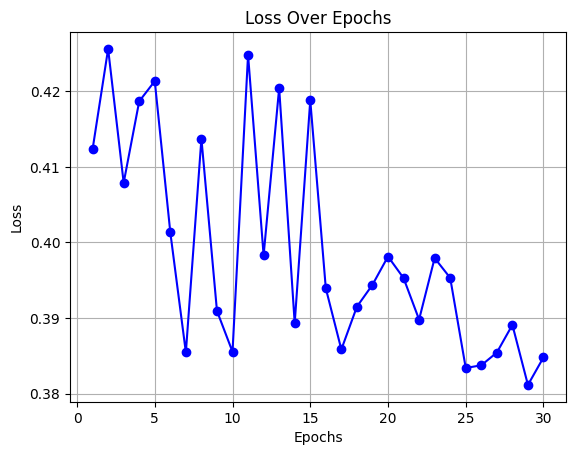

In [106]:
# Plot the loss graph
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

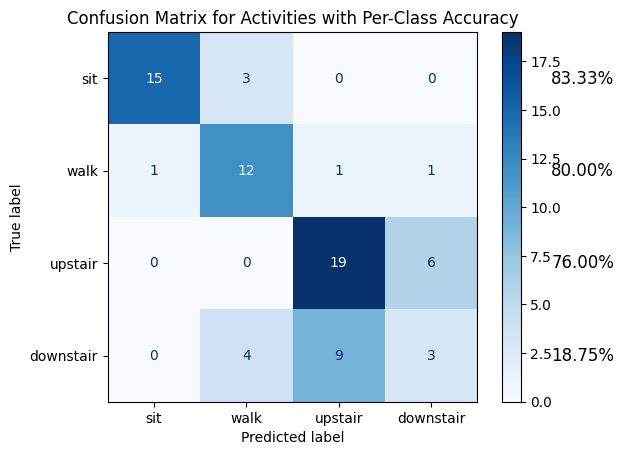

In [107]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair','downstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

In [108]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 1, Predicted: 3, Confidence: 0.9154
Full Probabilities: [0.029379215091466904, 0.03766971454024315, 0.017511988058686256, 0.9154391288757324]
True Label: 2, Predicted: 3, Confidence: 0.8265
Full Probabilities: [0.012199406512081623, 0.03148675337433815, 0.12984055280685425, 0.8264732956886292]
True Label: 2, Predicted: 3, Confidence: 0.7900
Full Probabilities: [0.011931823566555977, 0.06834960728883743, 0.1297091543674469, 0.7900094389915466]
True Label: 3, Predicted: 1, Confidence: 0.8853
Full Probabilities: [0.04698818176984787, 0.8853222727775574, 0.04487914964556694, 0.022810397669672966]
True Label: 3, Predicted: 1, Confidence: 0.9388
Full Probabilities: [0.016061872243881226, 0.9388251900672913, 0.015082070603966713, 0.030030837282538414]
True Label: 3, Predicted: 1, Confidence: 0.9117
Full Probabilities: [0.03692081570625305, 0.9117407202720642, 0.04204053059220314, 0.00929796788841486]
True Label: 1, Predicted: 2, Confidence: 0.7952
Full Probabilities: [0.0172142907